# Extract data

In [11]:
import pandas as pd
import numpy as np

if False:
    # Itérer à travers les années
    for year in range(2018, 2023):
        url = f"https://files.data.gouv.fr/geo-dvf/latest/csv/{year}/full.csv.gz"
        
        # Charger les données
        data = pd.read_csv(url, compression='gzip', header=0, sep=',', quotechar='"', low_memory=False, 
                            usecols=["type_local", "valeur_fonciere", "code_postal", "surface_reelle_bati", "longitude", "latitude"],
                            dtype={"code_postal": str})

        ### Remove rows with missing values
        data.dropna(inplace=True)

        ### Remove duplicates based on the columns "valeur_fonciere", "longitude", and "latitude"
        data.drop_duplicates(subset=["valeur_fonciere", "longitude", "latitude"], inplace=True, keep='last')

        data["code_postal"] = data["code_postal"].astype(str).str.zfill(5)
        
        # Calculate value per square meter
        data["value_per_sqm"] = data["valeur_fonciere"] / data["surface_reelle_bati"]
        
        # Grouper les données par code postal et type_local
        grouped = data.groupby(["code_postal", "type_local"]).agg({
            "valeur_fonciere": ["median", "mean", "std"],
            "latitude": ["median", "mean"],
            "longitude": ["median", "mean"],
            "surface_reelle_bati": ["median", "mean", "std"],
            "value_per_sqm": ["median", "mean", "std"]
        }).reset_index()
        
        # Renommer les colonnes du DataFrame résultant
        grouped.columns = ["Postal Code", "Property Type",
                        "Median Value", "Mean Value", "Std Dev Value", 
                        "Median Latitude", "Mean Latitude", 
                        "Median Longitude", "Mean Longitude", 
                        "Median Surface Area", "Mean Surface Area", "Std Dev Surface Area",
                        "Median Value SQM", "Mean Value SQM", "Std Dev Value SQM"]
        
        # Créer un DataFrame pour l'année en cours
        year_df = pd.DataFrame(grouped)
        
        # Chemin du fichier de sortie pour l'année en cours
        output_path = f"summarized_data_{year}.csv.gz"
        
        # Enregistrer le DataFrame dans un fichier CSV
        year_df.to_csv(output_path, index=False, compression='gzip')
        
        print(f"Summary data for year {year} saved to {output_path}")


Summary data for year 2018 saved to summarized_data_2018.csv.gz
Summary data for year 2019 saved to summarized_data_2019.csv.gz
Summary data for year 2020 saved to summarized_data_2020.csv.gz
Summary data for year 2021 saved to summarized_data_2021.csv.gz
Summary data for year 2022 saved to summarized_data_2022.csv.gz


In [ ]:
# file_paths = [
#     ("https://sotisimmo.s3.eu-north-1.amazonaws.com/geo_dvf_summarized_compressed/summarized_data_2018.csv.gz", "2018"),
#     ("https://sotisimmo.s3.eu-north-1.amazonaws.com/geo_dvf_summarized_compressed/summarized_data_2019.csv.gz", "2019"),
#     ("https://sotisimmo.s3.eu-north-1.amazonaws.com/geo_dvf_summarized_compressed/summarized_data_2020.csv.gz", "2020"),
#     ("https://sotisimmo.s3.eu-north-1.amazonaws.com/geo_dvf_summarized_compressed/summarized_data_2021.csv.gz", "2021"),
#     ("https://sotisimmo.s3.eu-north-1.amazonaws.com/geo_dvf_summarized_compressed/summarized_data_2022.csv.gz", "2022"),
# ]


# Get summary for all the years

In [29]:
import pandas as pd

def load_and_filter_data_by_department(file_path, department):
    """
    Load data from the given file path and filter it based on the given department number.
    
    Parameters:
    - file_path: Path to the CSV file.
    - department: Two-digit department number, e.g., "06" or "92".
    
    Returns:
    - Filtered dataframe containing data for the given department.
    """
    data = pd.read_csv(file_path, compression='gzip')
    start_range = int(department) * 1000
    end_range = start_range + 999
    return data[data["Postal Code"].between(start_range, end_range)]


file_paths = [
    ("./geo_dvf_summarized/summarized_data_2018.csv.gz", "2018"),
    ("./geo_dvf_summarized/summarized_data_2019.csv.gz", "2019"),
    ("./geo_dvf_summarized/summarized_data_2020.csv.gz", "2020"),
    ("./geo_dvf_summarized/summarized_data_2021.csv.gz", "2021"),
    ("./geo_dvf_summarized/summarized_data_2022.csv.gz", "2022"),
]

# Load all data files and store them in a dictionary for easy access
all_data = {}
for file_path, year in file_paths:
    all_data[year] = pd.read_csv(file_path, compression='gzip')

# Extract unique departments from all datasets
all_departments = set()
for year, data in all_data.items():
    departments = set(data["Postal Code"] // 1000)  # Extract two-digit department code
    all_departments.update(departments)
all_departments = list(all_departments)

# Flatten the data using the departments and the preloaded data
flattened_data = []
for department in all_departments:
    for year, data in all_data.items():
        filtered_data = data[data["Postal Code"].between(department*1000, department*1000 + 999)]
        for property_type in filtered_data["Property Type"].unique():
            property_filtered = filtered_data[filtered_data["Property Type"] == property_type]
            median_value_SQM = property_filtered["Median Value SQM"].median()
            mean_value_SQM = property_filtered["Median Value SQM"].mean()
            std_value_SQM = property_filtered["Median Value SQM"].std()
            median_value = property_filtered["Median Value"].median()
            mean_value = property_filtered["Median Value"].mean()
            std_value = property_filtered["Median Value"].std()

            flattened_data.append({
                "Year": year,
                "code_postal": department,
                "type_local": property_type,
                "median_value_SQM": median_value_SQM,
                "mean_value_SQM": mean_value_SQM,
                "std_value_SQM": std_value_SQM,
                "median_value": median_value,
                "mean_value": mean_value,
                "std_value": std_value,
            })

# Convert the flattened data into a DataFrame
flattened_df = pd.DataFrame(flattened_data)

# Convert the 'code_postal' column to a two-digit string format
flattened_df['code_postal'] = flattened_df['code_postal'].apply(lambda x: str(x).zfill(2))
flattened_df.head()





,Year,code_postal,type_local,median_value_SQM,mean_value_SQM,std_value_SQM,median_value,mean_value,std_value
0,2018,01,Appartement,1656.756757,2024.221319,1070.315747,110000.0,133521.612203,72237.224252
1,2018,01,Local industriel. commercial ou assimilé,777.777778,1088.326365,1203.765036,145000.0,176188.582627,136172.358334
2,2018,01,Maison,1810.433719,2139.224525,994.939986,183448.5,227130.366667,130942.430786
3,2019,01,Appartement,1792.692930,2135.666978,1002.745782,123750.0,142526.616667,68061.793333
4,2019,01,Local industriel. commercial ou assimilé,1111.394452,2149.403340,5267.500912,154500.0,223575.348966,308857.747459


# Write flattened df to csv

In [30]:
output_path = f"summarized_data_allyears.csv.gz"
flattened_df.to_csv(output_path, index=False, compression='gzip')


# Load data

In [31]:
from io import BytesIO
import pandas as pd
import requests

url = "https://sotisimmo.s3.eu-north-1.amazonaws.com/geo_dvf_summarized_summary.csv.gz"

response = requests.get(url)

### Store data in a buffer
buffer = BytesIO(response.content)

### Load data into a Pandas dataframe
df_pandas = pd.read_csv(buffer, compression='gzip', header=0, sep=',', quotechar='"', low_memory=False, 
                        dtype={"code_postal": str})


# Plot data

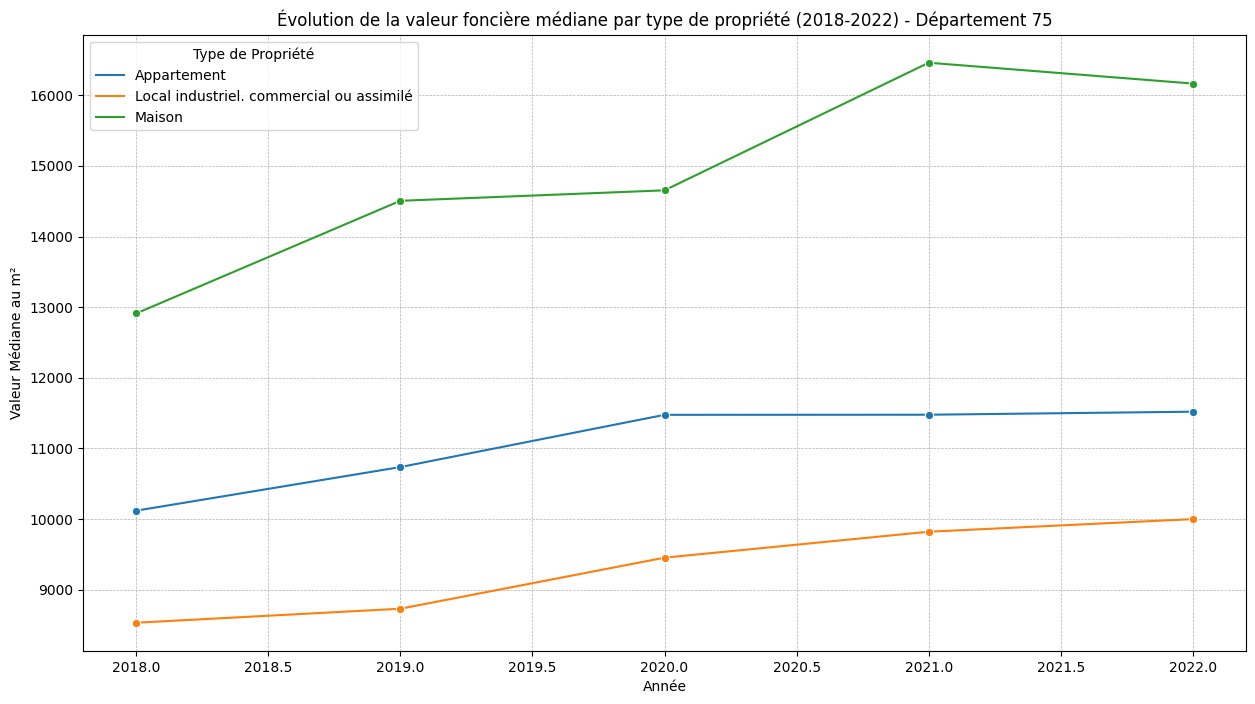

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_department_evolution(dataframe, department_code):
    """
    Plot the evolution of median property values over years for a given department.
    
    Parameters:
    - dataframe: DataFrame containing the data.
    - department_code: Two-digit code of the department (as a string).
    """
    # Filter data for the selected department
    dept_data = dataframe[dataframe['code_postal'] == department_code]
    
    plt.figure(figsize=(15, 8))
    
    # Use seaborn to plot the data for the selected department
    sns.lineplot(data=dept_data, x="Year", y="median_value", hue="type_local", marker="o")
    
    plt.title(f"Évolution de la valeur foncière médiane par type de propriété (2018-2022) - Département {department_code}")
    plt.xlabel("Année")
    plt.ylabel("Valeur Médiane au m²")
    plt.legend(title="Type de Propriété")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Example usage for department 06
plot_department_evolution(df_pandas, "75")


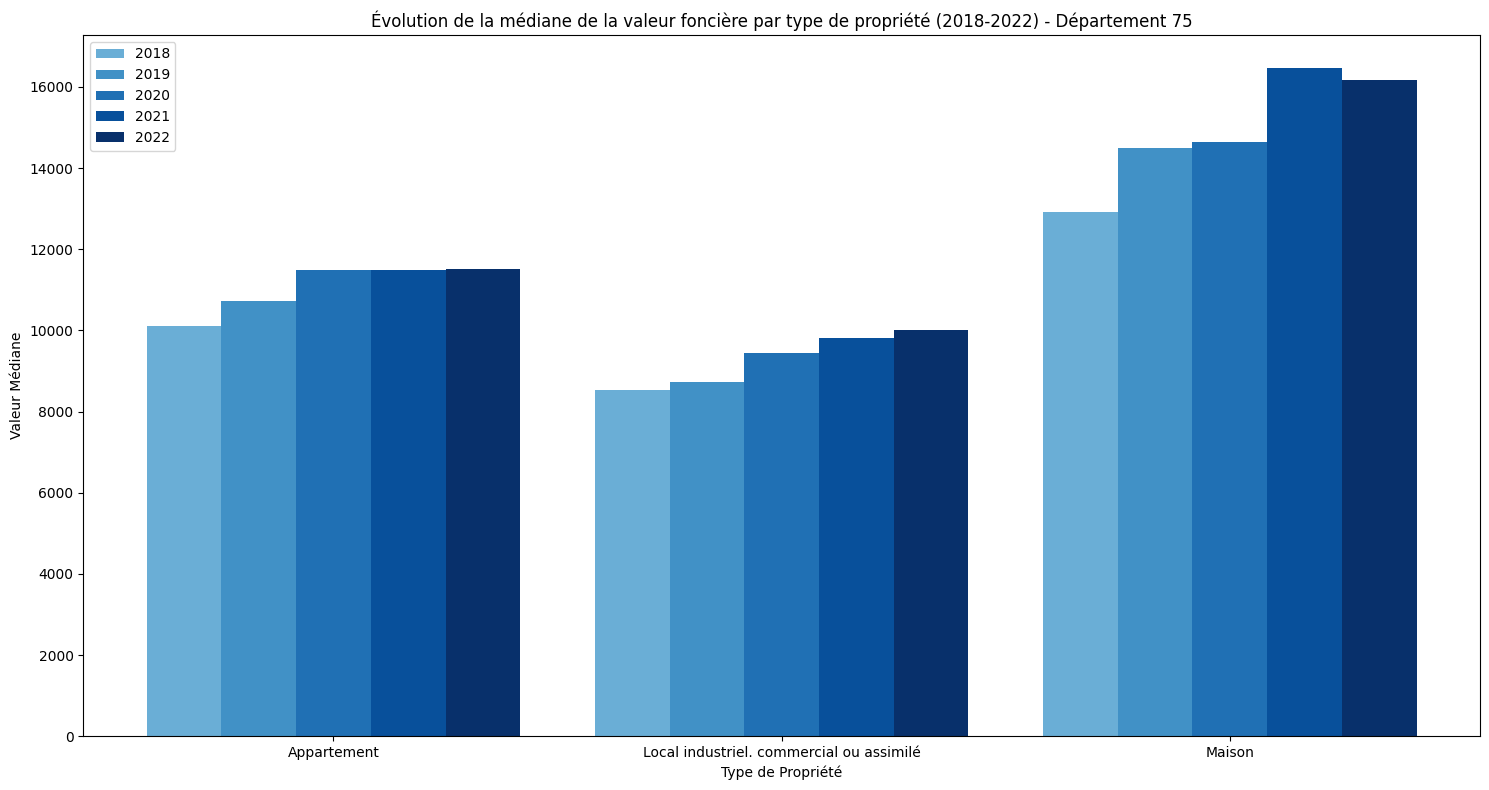

In [27]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def plot_department_bar_chart(dataframe, department_code):
    # Filter the dataframe by the provided department code
    dept_data = dataframe[dataframe['code_postal'] == department_code]

    # Pivot the dataframe for easier plotting
    medians_dpt = dept_data.pivot(index='type_local', columns='Year', values='median_value')

    # Define a colormap
    colormap = cm.Blues

    # Define the bar width
    bar_width = 0.2

    # Adjust the positions and the space between the property types
    adjusted_positions = [i + i*0.2 for i in range(len(medians_dpt.index))]

    # Generate a sequence of colors from the colormap
    linear_colors = [colormap(i) for i in np.linspace(0.5, 1, len(medians_dpt.columns))]

    # Plot stacked bar chart with adjusted spacing and the linearly increasing color palette
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot bars for each year
    for i, year in enumerate(medians_dpt.columns):
        ax.bar([p + i*bar_width for p in adjusted_positions], 
               medians_dpt[year], 
               width=bar_width, 
               label=year, 
               color=linear_colors[i])  # Use the linearly increasing color palette

    # Set x-axis ticks, labels, and other plot details
    ax.set_xticks([p + 2*bar_width for p in adjusted_positions])
    ax.set_xticklabels(medians_dpt.index)
    ax.set_title(f"Évolution de la médiane de la valeur foncière par type de propriété (2018-2022) - Département {department_code}")
    ax.set_xlabel("Type de Propriété")
    ax.set_ylabel("Valeur Médiane")
    ax.legend()
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    plt.tight_layout()
    plt.show()

# Example usage for department 06
plot_department_bar_chart(df_pandas, "75")
